#Домашнее задание 1. Классические линейные модели.
В данном ноутбуке будут приведены примеры построения моделей из лекций 1 и 2, после чего предлагается воспроизвести процедуру настройки моделей на других временных рядах.

In [ ]:
!pip install -q arch pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.9/982.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.3 MB/s eta 0:00:00


In [ ]:
import os
import sys

import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

import scipy.stats as scs
from arch import arch_model

import matplotlib as mpl
import matplotlib.pyplot as plt


## Модель SARIMA
- Seasonal ARIMA = SARIMA
$$ \text{SARIMA}(p, d, q)(P, D, Q)_S $$
    - Базовые компоненты
        - p: autoregressive order
        - d: differencing order
        - q: moving average order
    - Сезонные компоненты
        - P: seasonal autoregressive order
        - D: seasonal differencing order
        - Q: seasonal moving average order
        - S: длина сезона
- Примеры моделей ARIMA и SARIMA
    - ARIMA(2, 0, 1):
$$ x_t = a_1 x_{t-1} + a_2 x_{t-2} + m_1 \epsilon_{t-1} + \epsilon_t $$
    - SARIMA(0,0,0)(2, 0, 1)_7:
$$ x_t = a_7 x_{t-7} + a_{14} x_{t-14} + m_y \epsilon_{t-7} + \epsilon_t $$

- Сезонное дифференцирование
    - Вычитание из текущего значения его значения, соответствующего прошлому сезону
$$ \Delta x_t = x_t - x_{t-S} $$

## Исследуемый временной ряд
Сгенерируем искусственный временной ряд с трендом, сезонной компонентой и шумом.

In [ ]:
N = 700
trend = np.linspace(0, 2, N)**3
season = 1.5*np.sin(2*np.pi/(4*12) * np.arange(N))
wn = np.random.normal(loc=0.0, scale=0.5, size=N)
heteroskedastic = np.linspace(1, 2, N)
ts = trend + heteroskedastic*season + wn

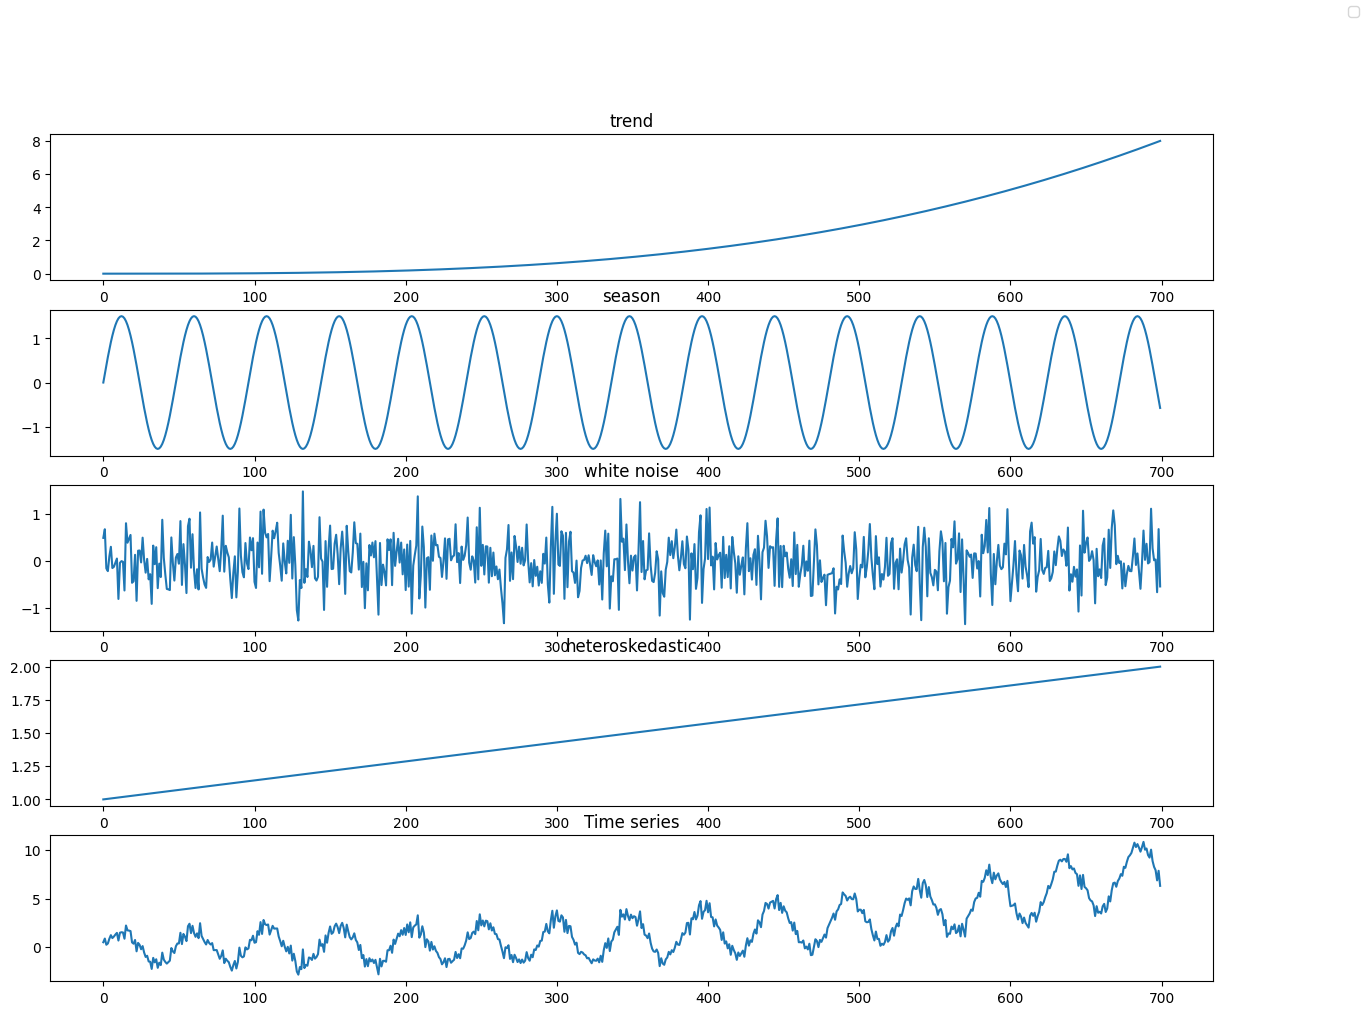

In [ ]:
fig, axs = plt.subplots(5, 1, figsize = (15,11))
axs[0].plot(trend)
axs[0].set_title('trend')
axs[1].plot(season)
axs[1].set_title('season')
axs[2].plot(wn)
axs[2].set_title('white noise')
axs[3].plot(heteroskedastic)
axs[3].set_title('heteroskedastic')
axs[4].plot(ts)
axs[4].set_title('Time series')
fig.legend()
fig.show()

## Последовательность действия для построения ARIMA модели
1. Строится график ряда, идентифицируются необычные значения.
2. Если ряд сильно нестационарный подбирается порядок дифференцирования.
  - Рекомендуется сначала выбрать поряд сезонного дифференцирования, потом обычного дифференцирования.

4. Анализируются ACF/[PACF](http://www.machinelearning.ru/wiki/index.php?title=%D0%A7%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%B0%D1%8F_%D0%B0%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D1%80%D1%80%D0%B5%D0%BB%D1%8F%D1%86%D0%B8%D1%8F
), чтобы выбрать начальные приближения для параметров.
  - p - последний значимый несезонный лаг (меньше сезонного периода) по [PACF](http://www.machinelearning.ru/wiki/index.php?title=%D0%A7%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%B0%D1%8F_%D0%B0%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D1%80%D1%80%D0%B5%D0%BB%D1%8F%D1%86%D0%B8%D1%8F
)
  - q - последний значимый несезонный лаг (меньше сезонного периода) по ACF
  - P - последний значимый сезонный лаг по [PACF](http://www.machinelearning.ru/wiki/index.php?title=%D0%A7%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%B0%D1%8F_%D0%B0%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D1%80%D1%80%D0%B5%D0%BB%D1%8F%D1%86%D0%B8%D1%8F
)
  - Q - последний значимый сезонный лаг по ACF
5. Обучаются модели-кандидаты, в окрестностях начального приближения, сравнивается их AIC/BIC.
6. Остатки полученной модели исследуются на несмещённость, стационарность и неавтокоррелированность; если предположения невыполняются,исследуются модификациимодели.

___
"Лаг" - величина сдвига в ACF/PACF; значимость лага - выход значения за пределы доверительного интервала, центрированного в нуле (см. комментарий ниже)
___

При обучении моделей SARIMAX одновременное нахождение оптимальных значений (p, q, d, P, Q, D) является возможным (см. pmdarima.auto_arima), но даже в таком случае удобно определить начальные значения параметров на основе анализа автокорреляционной функции ряда.

Конкретно, методы statsmodels.tsa.api.plot_acf и statsmodels.tsa.api.plot_pacf позволяют построить автокорреляционную (ACF) и частичную автокорреляционную (PACF) функции ряда, а также построить для их значений доверительные интервалы. Доверительные интервалы на этих графиках отображаются на фоне в виде сплошной области, симметричной относительно оси абсцисс.

По графикам этих функций определяются последние моменты времени, когда их значения существенно отличаются от нуля (т.е. не попадают в доверительный интервал). Эти значения, делённые нацело на подобранное значение сезонного периода S, и равны P и Q для PACF и ACF соответственно.

Далее осуществляется дифференцирование ряда (обычное и сезонное), порядки дифференцирования определяются вручную. Наконец, для нового преобразованного ряда вновь строим ACF и PACF и по самым последним их значениям, выходящим за пределы доверительного интервала, определяем q и p соответственно. Ниже приведен пример.

## Графики автокорреляционной функции

Нужно использовать ACF и PACF для проверки сезонности данных.
Из графика выше видно, что временной ряд не является стационарным, поэтому, вероятно, следует исключить из него тренд.
Удалить тренд можно либо с помощью вычитания тренда напрямую, либо использовать дифференцирование временного ряда.

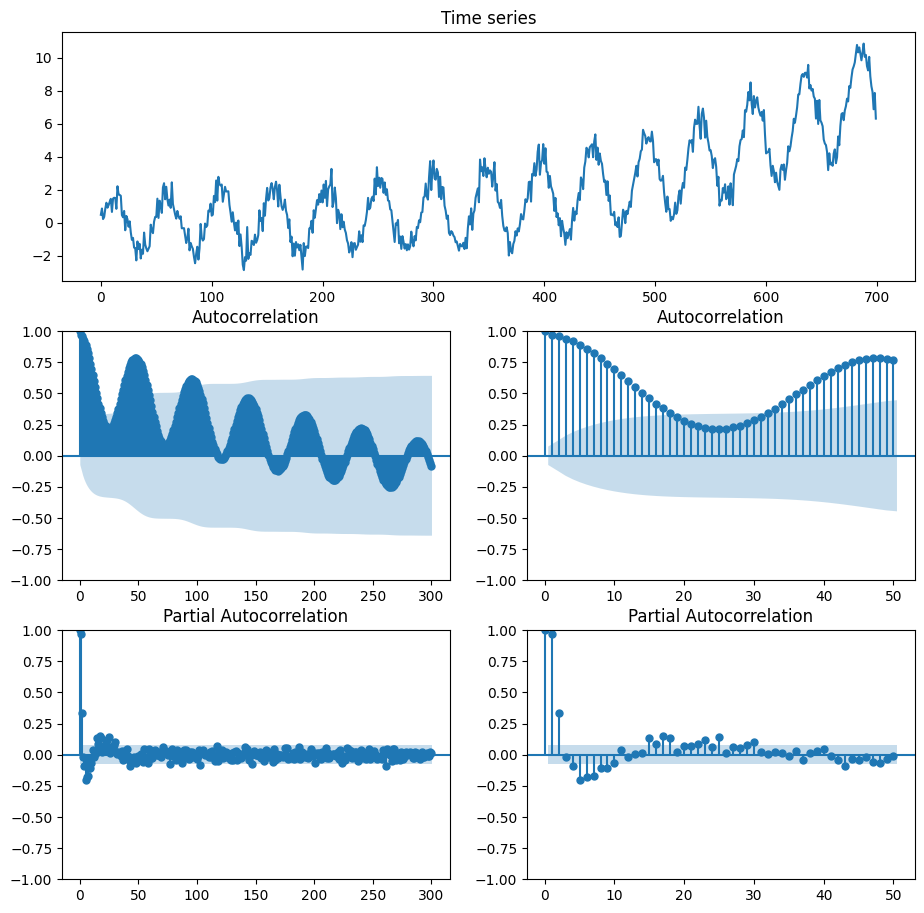

In [ ]:
fig, axs = plt.subplots(3, 2, figsize = (11,11))
axs[0, 0].remove()
axs[0, 1].remove()

gs = axs[0, 0].get_gridspec()
axbig = fig.add_subplot(gs[0, :2])
axbig.plot(ts)
axbig.set_title('Time series')

smt.graphics.plot_acf(ts, lags=300, ax=axs[1,0], alpha=0.05)
smt.graphics.plot_pacf(ts, lags=300, ax=axs[2,0], alpha=0.05)

smt.graphics.plot_acf(ts, lags=50, ax=axs[1,1], alpha=0.05)
smt.graphics.plot_pacf(ts, lags=50, ax=axs[2,1], alpha=0.05)
plt.show()

Выводы:
1. Есть тренд - используем дифференцирование d = 1, и явно выделенная сезонная компонента D = 1.
2. Сезонный порядок Q = 2, P = 3.

In [ ]:
ts_diff = np.diff(ts, n = 1)
ts_diff = np.diff(ts_diff, n = 48)

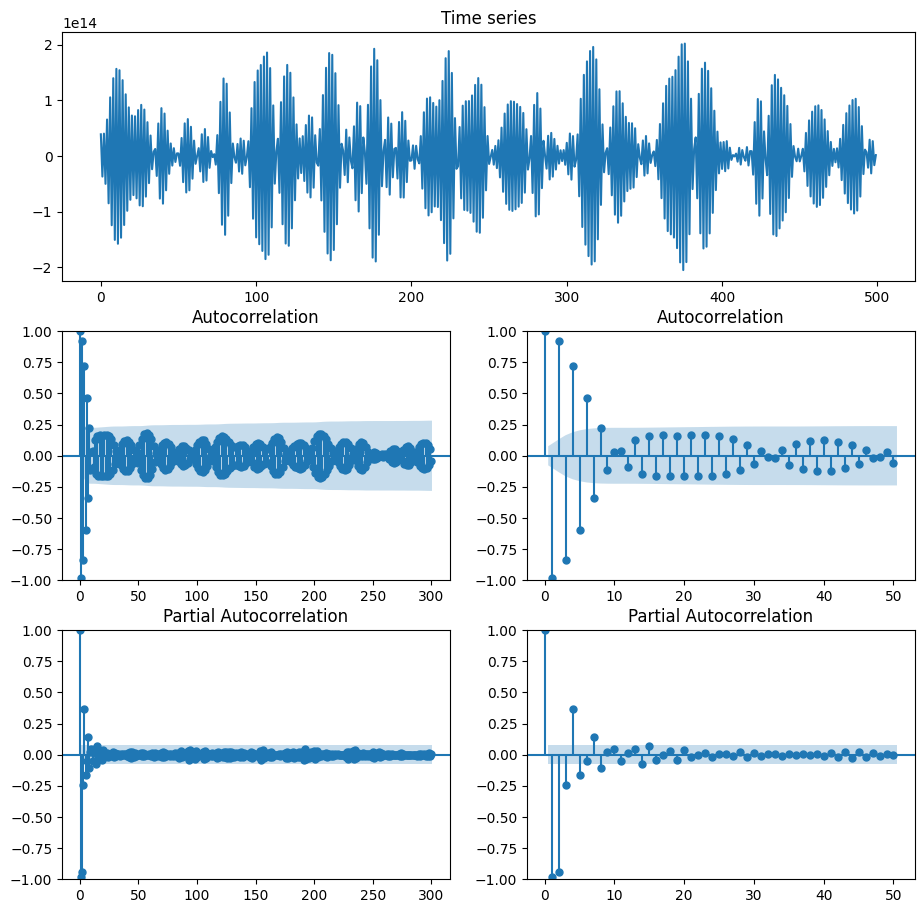

In [ ]:
fig, axs = plt.subplots(3, 2, figsize = (11,11))
axs[0, 0].remove()
axs[0, 1].remove()

gs = axs[0, 0].get_gridspec()
axbig = fig.add_subplot(gs[0, :2])
axbig.plot(ts_diff[:500])
axbig.set_title('Time series')

smt.graphics.plot_acf(ts_diff, lags=300, ax=axs[1,0], alpha=0.05)
smt.graphics.plot_pacf(ts_diff, lags=300, ax=axs[2,0], alpha=0.05)

smt.graphics.plot_acf(ts_diff, lags=50, ax=axs[1,1], alpha=0.05)
smt.graphics.plot_pacf(ts_diff, lags=50, ax=axs[2,1], alpha=0.05)
plt.show()

Выводы:
1. p = 4.
2. q = 9.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# order=(p, d, q),
# seasonal_order=(P, D, Q, S)
model = SARIMAX(ts, order=(4, 1, 9), seasonal_order=(2, 1, 1, 48))

results = model.fit()
results.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  700
Model:             SARIMAX(4, 1, 9)x(2, 1, [1], 48)   Log Likelihood                -552.492
Date:                              Wed, 09 Oct 2024   AIC                           1138.985
Time:                                      19:42:23   BIC                           1215.119
Sample:                                           0   HQIC                          1168.513
                                              - 700                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5250      0.132     -3.964      0.000      -0.785      -0.265
ar.L2         -0.6253      0.088     -7.122      0.000      -0.797      -0.453
ar.L3         -0.5626      0.086     -6.560      0.000      -0.731      -0.394
ar.L4         -0.9127      0.123     -7.430      0.000      -1.153      -0.672
ma.L1         -0.3473      0.146     -2.375      0.018      -0.634      -0.061
ma.L2          0.2196      0.172      1.278      0.201      -0.117       0.556
ma.L3          0.0040      0.172      0.023      0.981      -0.333       0.341
ma.L4          0.5009      0.172      2.907      0.004       0.163       0.839
ma.L5         -0.8642      0.113     -7.621      0.000      -1.086      -0.642
ma.L6          0.0284      0.060      0.477      0.634      -0.089       0.145
ma.L7         -0.0236      0.055     -0.427      0.669      -0.132       0.085
ma.L8         -0.0159      0.054     -0.293      0.770      -0.123       0.091
ma.L9         -0.1042      0.052     -1.986      0.047      -0.207      -0.001
ar.S.L48      -0.1488      0.089     -1.672      0.095      -0.323       0.026
ar.S.L96      -0.0499      0.068     -0.736      0.462      -0.183       0.083
ma.S.L48      -0.6567      0.085     -7.705      0.000      -0.824      -0.490
sigma2         0.2996      0.017     17.697      0.000       0.266       0.333
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                 3.51
Prob(Q):                              0.58   Prob(JB):                         0.17
Heteroskedasticity (H):               0.93   Skew:                             0.15
Prob(H) (two-sided):                  0.59   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# import pmdarima as pm

In [ ]:
# model1 = pm.auto_arima(
#     y = ts,
#     seasonal=True,
#     m=48,
#     start_p = 1, max_p = 9,
#     start_d = 1, max_d = 1,
#     start_q = 2, max_q = 11,
#     start_P = 1, max_P = 5,
#     start_D = 1, max_D = 1,
#     start_Q = 1, max_Q = 3,
#     # trace=True,
#     error_action='ignore',
#     # suppress_warnings=True
# )

# print(model1.summary())

# Задание
- Выбрать один из временных рядов из списка.(или любой другой временной ряд который вы захотите - главное, чтобы он не был слишком простым)
- Визуализировать ACF и PACF.
- Построить и выбрать лучшую AR, ARMA, SARIMA модели.(для последней можно использовать auto arima)
- К лучшей модели из предыдущих попробовать добавить GARCH.
- Проанализировать результаты работы моделей (Анализ ошибки) для каждой из моделей
  - Графики остатков, проверить на нормальность
  - Оценить горизонт прогнозирования через отложенную выборку (~20% )

## Выбор временного ряда

In [ ]:
DATA_PATH = "https://raw.githubusercontent.com/intsystems/MathematicalForecastingMethods/main/data/AirPassengers.csv"
# DATA_PATH = "https://raw.githubusercontent.com/intsystems/MathematicalForecastingMethods/main/data/Electric_Production.csv"
# DATA_PATH = "https://raw.githubusercontent.com/intsystems/MathematicalForecastingMethods/main/data/accident_UK.csv"
# DATA_PATH = "https://raw.githubusercontent.com/intsystems/MathematicalForecastingMethods/main/data/shampoo_sales.csv"
# DATA_PATH = "https://raw.githubusercontent.com/intsystems/MathematicalForecastingMethods/main/data/monthly_beer_production_in_austr.csv"

In [ ]:
df = pd.read_csv(DATA_PATH)

df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
